In [1]:
!git clone https://github.com/ITMO-NSS-team/BAMT.git

Cloning into 'BAMT'...
remote: Enumerating objects: 1421, done.
remote: Counting objects: 100% (864/864), done.
remote: Compressing objects: 100% (634/634), done.
remote: Total 1421 (delta 385), reused 649 (delta 210), pack-reused 557
Receiving objects: 100% (1421/1421), 71.56 MiB | 5.45 MiB/s, done.
Resolving deltas: 100% (565/565), done.


In [3]:
import os
os.chdir('BAMT')
# install req.txt
!pip install -r requirements.txt

     |████████████████████████████████| 109 kB 2.3 MB/s            
     |████████████████████████████████| 829 kB 2.5 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 248 kB 3.0 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 965 kB 3.0 MB/s            
     |████████████████████████████████| 3.3 MB 3.0 MB/s            
     |████████████████████████████████| 788 kB 3.7 MB/s            
     |████████████████████████████████| 1.4 MB 10.7 MB/s            
     |████████████████████████████████| 133 kB 5.4 MB/s            
     |████████████████████████████████| 303 kB 8.1 MB/s            
     |████████████████████████████████| 61 kB 611 kB/s             
     |████████████████████████████████| 7.2 MB 8.4 MB/s            
     |████████████████████████████████| 17.0 MB 5.7 MB/s            
     |████████████████████████████████| 11.6 MB 10.5 MB/s            
     |████████████████████████

In [9]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [23]:
import os
os.chdir('/Users/Deadvitekchpool/Documents/Multivariate Analysis/Lab3/BAMT')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from bayesian.train_bn import structure_learning, parameter_learning
from preprocess.discretization import get_nodes_type, discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from bayesian.calculate_accuracy import calculate_acc
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN

data = pd.read_excel('../../Lab2/Absenteeism_at_work_AAA/Absenteeism_at_work.xls')
selected_features = ['Son', 'Education', 'Reason for absence', 'Service time', 'Age', 'Absenteeism time in hours', 'Body mass index', 'Distance from Residence to Work', 'Transportation expense', 'Disciplinary failure']
data = data[selected_features]
data['Service time'] = data['Service time'].apply(lambda x: float(x))
data['Age'] = data['Age'].apply(lambda x: float(x))
data['Absenteeism time in hours'] = data['Absenteeism time in hours'].apply(lambda x: float(x))
data['Body mass index'] = data['Body mass index'].apply(lambda x: float(x))
data['Distance from Residence to Work'] = data['Distance from Residence to Work'].apply(lambda x: float(x))
data['Transportation expense'] = data['Transportation expense'].apply(lambda x: float(x))
data['Reason for absence'] = data['Reason for absence'].apply(lambda x: str(x))
data['Education'] = data['Education'].apply(lambda x: str(x))
data['Son'] = data['Son'].apply(lambda x: str(x))
data['Disciplinary failure'] = data['Disciplinary failure'].apply(lambda x: str(x))
data.head()

,Son,Education,Reason for absence,Service time,Age,Absenteeism time in hours,Body mass index,Distance from Residence to Work,Transportation expense,Disciplinary failure
0,2,1,26,13.0,33.0,4.0,30.0,36.0,289.0,0
1,1,1,0,18.0,50.0,0.0,31.0,13.0,118.0,1
2,0,1,23,18.0,38.0,2.0,31.0,51.0,179.0,0
3,2,1,7,14.0,39.0,4.0,24.0,5.0,279.0,0
4,2,1,23,13.0,33.0,2.0,30.0,36.0,289.0,0


Step 4. Build a Bayesian network for chosen set of variables. Choose its structure on the basis
of multivariate analysis and train distributions in nodes using chosen algorithm.

Step 5. Build a Bayesian network for the same set of variables but using 2 chosen algorithms
for structural learning.

Step 6. Analyze a quality of sampled target variables from the point of view of problem
statement (e.g. prediction, gap filling, synthetic generation).

In [24]:
nodes_type = get_nodes_type(data)
print(nodes_type)
nodes_sign = get_nodes_sign(data)
print(nodes_sign)

{'Son': 'disc', 'Education': 'disc', 'Reason for absence': 'disc', 'Service time': 'cont', 'Age': 'cont', 'Absenteeism time in hours': 'cont', 'Body mass index': 'cont', 'Distance from Residence to Work': 'cont', 'Transportation expense': 'cont', 'Disciplinary failure': 'disc'}
{'Service time': 'pos', 'Age': 'pos', 'Absenteeism time in hours': 'pos', 'Body mass index': 'pos', 'Distance from Residence to Work': 'pos', 'Transportation expense': 'pos'}


In [27]:
coded_data, coder = code_categories(data, 'label', ['Reason for absence', 'Education', 'Son', 'Disciplinary failure'])
discrete_data, coder = discretization(coded_data, 'equal_frequency', ['Service time', 'Age', 'Absenteeism time in hours', 'Body mass index', 'Distance from Residence to Work', 'Transportation expense'])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:235: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [33]:
bn = structure_learning(discrete_data, 'HC', nodes_type, 'K2')
bn

{'V': ['Son',
  'Education',
  'Reason for absence',
  'Service time',
  'Age',
  'Absenteeism time in hours',
  'Body mass index',
  'Distance from Residence to Work',
  'Transportation expense',
  'Disciplinary failure'],
 'E': [['Son', 'Service time'],
  ['Son', 'Age'],
  ['Son', 'Distance from Residence to Work'],
  ['Son', 'Transportation expense'],
  ['Son', 'Body mass index'],
  ['Son', 'Education'],
  ['Education', 'Service time'],
  ['Education', 'Transportation expense'],
  ['Reason for absence', 'Absenteeism time in hours'],
  ['Reason for absence', 'Son'],
  ['Service time', 'Distance from Residence to Work'],
  ['Service time', 'Age'],
  ['Service time', 'Transportation expense'],
  ['Service time', 'Body mass index'],
  ['Age', 'Body mass index'],
  ['Body mass index', 'Distance from Residence to Work'],
  ['Transportation expense', 'Distance from Residence to Work'],
  ['Transportation expense', 'Age'],
  ['Transportation expense', 'Body mass index'],
  ['Disciplinary fa

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

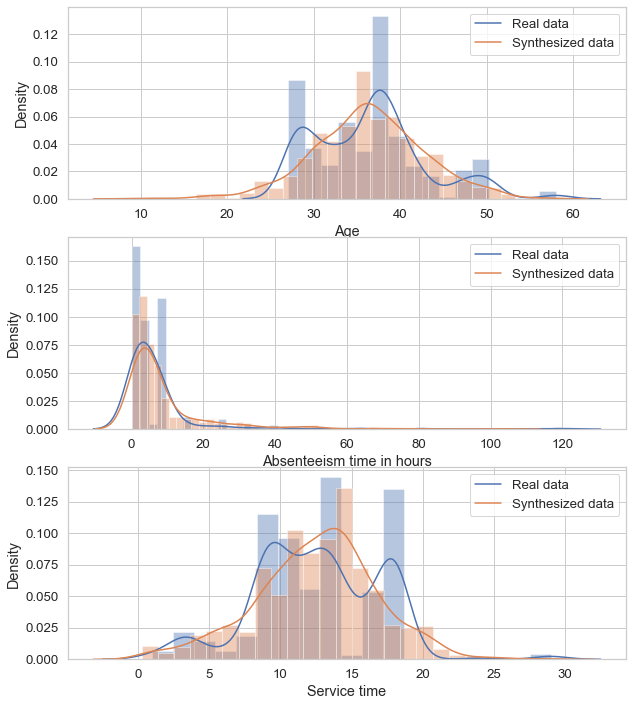

In [35]:
params = parameter_learning(data, nodes_type, bn, 'simple')
save_structure(bn, 'workers_net_structure')
skel = read_structure('workers_net_structure')
save_params(params, 'workers_net_param')
params = read_params('workers_net_param')
workers_bn = HyBayesianNetwork(skel, params)
synth_df = generate_synthetics(workers_bn, nodes_sign, 'simple', 740)

sns.set(style      = 'whitegrid',
        font_scale = 1.2,
        rc         = {'figure.figsize':(30, 10)})

fix, ax = plt.subplots(3, 1, figsize=(10, 12))

sns.distplot(data['Age'], ax=ax[0])
sns.distplot(synth_df['Age'], ax=ax[0])
ax[0].legend(['Real data', 'Synthesized data'])

sns.distplot(data['Absenteeism time in hours'], ax=ax[1])
sns.distplot(synth_df['Absenteeism time in hours'], ax=ax[1])
ax[1].legend(['Real data', 'Synthesized data'])

sns.distplot(data['Service time'], ax=ax[2])
sns.distplot(synth_df['Service time'], ax=ax[2])
ax[2].legend(['Real data', 'Synthesized data'])

print(calculate_acc(workers_bn, data, ['Age', 'Absenteeism time in hours', 'Service time'], 'simple')[0:2])

In [36]:
bn_evo = structure_learning(discrete_data, 'evo', nodes_type, 'MI')
bn_evo

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  warnings.warn(


Best metric is 9.9622
Generation num: 0
max_depth: 6, no improvements: 0
spent time: 0.1 min
Best metric is 9.9622
Generation num: 1
max_depth: 6, no improvements: 1
spent time: 0.1 min
Best metric is 9.785900000000002
Generation num: 2
max_depth: 6, no improvements: 0
spent time: 0.2 min
Best metric is 9.756499999999999
Generation num: 3
max_depth: 6, no improvements: 0
spent time: 0.2 min
Best metric is 8.7884
Generation num: 4
max_depth: 6, no improvements: 0
spent time: 0.3 min
Best metric is 8.0521
Generation num: 5
max_depth: 6, no improvements: 0
spent time: 0.4 min
Best metric is 8.0521
Generation num: 6
max_depth: 6, no improvements: 1
spent time: 0.4 min
Best metric is 8.020199999999999
Generation num: 7
max_depth: 6, no improvements: 0
spent time: 0.6 min
Best metric is 8.020199999999999
Generation num: 8
max_depth: 6, no improvements: 1
spent time: 0.7 min
Best metric is 8.020199999999999
Generation num: 9
max_depth: 6, no improvements: 2
spent time: 0.8 min
Best metric is 

{'V': ['Son',
  'Education',
  'Reason for absence',
  'Service time',
  'Age',
  'Absenteeism time in hours',
  'Body mass index',
  'Distance from Residence to Work',
  'Transportation expense',
  'Disciplinary failure'],
 'E': [['Distance from Residence to Work', 'Body mass index'],
  ['Disciplinary failure', 'Service time'],
  ['Age', 'Service time'],
  ['Reason for absence', 'Distance from Residence to Work'],
  ['Absenteeism time in hours', 'Age'],
  ['Transportation expense', 'Age'],
  ['Son', 'Reason for absence'],
  ['Education', 'Reason for absence']]}

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

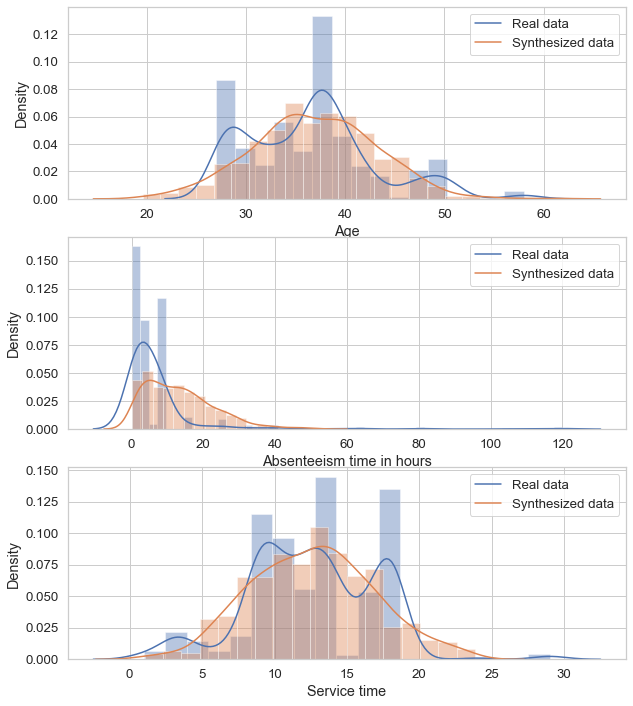

In [37]:
params_evo = parameter_learning(data, nodes_type, bn_evo, 'simple')
save_structure(bn_evo, 'workers_net_structure_evo')
skel_evo = read_structure('workers_net_structure_evo')
save_params(params_evo, 'workers_net_param_evo')
params_evo = read_params('workers_net_param_evo')
workers_bn_evo = HyBayesianNetwork(skel_evo, params_evo)
synth_df_evo = generate_synthetics(workers_bn_evo, nodes_sign, 'simple', 740)

sns.set(style      = 'whitegrid',
        font_scale = 1.2,
        rc         = {'figure.figsize':(30, 10)})

fix, ax = plt.subplots(3, 1, figsize=(10, 12))

sns.distplot(data['Age'], ax=ax[0])
sns.distplot(synth_df_evo['Age'], ax=ax[0])
ax[0].legend(['Real data', 'Synthesized data'])

sns.distplot(data['Absenteeism time in hours'], ax=ax[1])
sns.distplot(synth_df_evo['Absenteeism time in hours'], ax=ax[1])
ax[1].legend(['Real data', 'Synthesized data'])

sns.distplot(data['Service time'], ax=ax[2])
sns.distplot(synth_df_evo['Service time'], ax=ax[2])
ax[2].legend(['Real data', 'Synthesized data'])

print(calculate_acc(workers_bn_evo, data, ['Age', 'Absenteeism time in hours', 'Service time'], 'simple')[0:2])